In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [2]:
''' SIMLUATE PRICE SERIES'''

SIZE = 10000

k = 3
a = 0.9
p_series = np.ndarray((SIZE,))
b_series = np.ndarray((SIZE,))

p_series[0] = 0
b_series[0] = 0

for i in range(1, SIZE):
    p_series[i] =  p_series[i - 1] + b_series[i - 1] + k * np.random.normal()
    b_series[i] = a * b_series[i - 1] + np.random.normal()

R = np.max(p_series) - np.min(p_series)
z_series = np.exp(p_series / R)

# plt.plot(z_series)

In [3]:
from keras import layers

INPUT_SIZE = 10
input = layers.Input(shape=(INPUT_SIZE,))
x = layers.Dense(10, activation='relu')(input)
x = layers.Dense(1, activation='tanh')(x)
F_curr_model = keras.Model(inputs=input, outputs=x)
F_prev_model = keras.Model(inputs=input, outputs=x)
F_curr_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense (Dense)               (None, 10)                110       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


In [4]:
def calc_returns(mu, riskyRt_arr, action_arr, riskfreeRt=0, delta=0):
    '''Calculates the returns (Rt) as a set (array).
       For an input array of size N, returns an array of size N-1. The first term gets cut off.'''

    Ft_curr = action_arr[1:] # Ft
    Ft_prev = action_arr[:-1] # Ft - 1

    z_curr = riskyRt_arr[1:] # zt
    z_prev = riskyRt_arr[:-1] # zt - 1

    rt_curr = z_curr - z_prev # rt

    return mu * (riskfreeRt + Ft_prev * (rt_curr - riskfreeRt) - delta * np.abs(Ft_curr - Ft_prev))

In [4]:
def calc_return(mu, rt, Ft_curr, Ft_prev, rft=0, delta=0):
    '''Calculates the returns (Rt) on-line.'''

    return mu * (rft + Ft_prev * (rt - rft) - delta * tf.math.abs(Ft_curr - Ft_prev))

In [ ]:
def calc_DSR(n, returns_arr):
    '''Calculates the differential Sharpe ratios (DSR, Dt) as a set (array).
       For an input array of size N, returns an array of size N-1. The first term gets cut off.'''
    
    size = returns_arr.shape[0]
    At = np.ndarray((size,))
    Bt = np.ndarray((size,))
    dDt_dRt = np.ndarray((size,))

    At[0] = 0
    Bt[0] = 0

    for i in range(1, size):
        At[i] = At[i - 1] + n * (returns_arr[i] - At[i - 1])
        Bt[i] = Bt[i - 1] + n * (returns_arr[i] ** 2 - At[i - 1])
    
    dDt_dRt = (Bt[:-1] - At[:-1] * returns_arr[1:]) / ((Bt[:-1] - At[:-1] ** 2) ** 1.5)

In [5]:
def calc_DSR(n, Rt, At_prev, Bt_prev):
    '''Calculates the differential Sharpe ratios (DSR, Dt) on-line.'''

    At_curr = At_prev + n * (Rt - At_prev)
    Bt_curr = Bt_prev + n * (Rt ** 2 - Bt_prev)

    dDt_dRt = (Bt_prev - At_prev * Rt) / ((Bt_prev - At_prev ** 2) ** 1.5)

    return dDt_dRt, At_curr, Bt_curr

In [9]:
t = 5 + INPUT_SIZE
rho = 0.01

with tf.GradientTape(persistent=True) as tape:

    rt = 1
    mu = 3
    F_prev = F_prev_model(z_series[t - 1 - INPUT_SIZE:t - 1][np.newaxis, :])
    F_curr = F_curr_model(z_series[t - INPUT_SIZE:t][np.newaxis, :])
    Rt = calc_return(mu, rt, F_curr, F_prev)

    At_prev = 0
    Bt_prev = 1

    dDt_dRt, At_curr, Bt_curr = calc_DSR(0.01, Rt, At_prev, Bt_prev)

dRt_dFcurr = tape.gradient(Rt, F_curr)
dRt_dFprev = tape.gradient(Rt, F_prev)
print(dRt_dFcurr)
dFcurr_dThetacurr = tape.gradient(F_curr, F_curr_model.trainable_variables)
dFprev_dThetaprev = tape.gradient(F_prev, F_prev_model.trainable_variables)


gradient_update = []
for i in range(len(dFcurr_dThetacurr)):
    gradient_update.append(rho * dDt_dRt * (dRt_dFcurr * dFcurr_dThetacurr[i] + dRt_dFprev * dFprev_dThetaprev[i]))


tf.Tensor([[-0.]], shape=(1, 1), dtype=float32)
[<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[-2.8303205e-03,  3.6167494e-05,  0.0000000e+00,  2.1593079e-03,
        -1.6811885e-03,  0.0000000e+00, -2.1597650e-04, -2.0770312e-03,
         0.0000000e+00,  0.0000000e+00],
       [-2.8317044e-03,  3.6185178e-05,  0.0000000e+00,  2.1603638e-03,
        -1.6820106e-03,  0.0000000e+00, -2.1608210e-04, -2.0780468e-03,
         0.0000000e+00,  0.0000000e+00],
       [-2.8400086e-03,  3.6291294e-05,  0.0000000e+00,  2.1666992e-03,
        -1.6869431e-03,  0.0000000e+00, -2.1671578e-04, -2.0841407e-03,
         0.0000000e+00,  0.0000000e+00],
       [-2.8483127e-03,  3.6397407e-05,  0.0000000e+00,  2.1730345e-03,
        -1.6918757e-03,  0.0000000e+00, -2.1734944e-04, -2.0902348e-03,
         0.0000000e+00,  0.0000000e+00],
       [-2.8510808e-03,  3.6432779e-05,  0.0000000e+00,  2.1751462e-03,
        -1.6935199e-03,  0.0000000e+00, -2.1756068e-04, -2.0922660e-03,
         0.000000

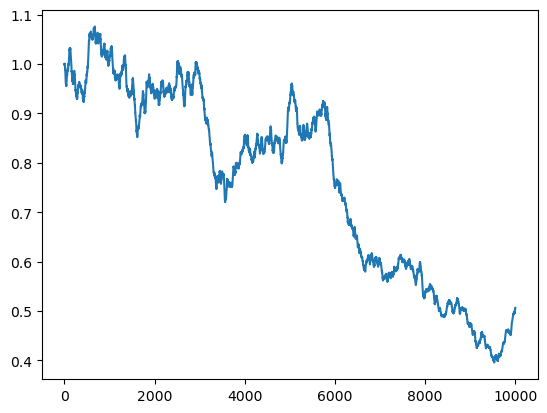